# Fake News Detection

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast

In [2]:
# Load Fake and True news CSVs
fake_df = pd.read_csv("ISOT/Fake.csv")
true_df = pd.read_csv("ISOT/True.csv")

# Add labels
fake_df["label"] = 0  # Fake = 0
true_df["label"] = 1  # True = 1

print("Fake shape:", fake_df.shape)
print("True shape:", true_df.shape)

Fake shape: (23481, 5)
True shape: (21417, 5)


In [3]:
# Merge into single dataset
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head())

                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  


In [4]:
# Drop missing values
df = df.dropna(subset=["title", "text"])

# Combine title + text into a single column
df["content"] = df["title"] + " " + df["text"]

# Remove extra whitespaces/newlines
df["content"] = df["content"].str.replace(r"\s+", " ", regex=True).str.strip()

print(df["content"].iloc[0][:500])  # Preview first 500 chars

Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washingto


In [5]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["content"],
    df["label"],
    test_size=0.2,      # 80% train, 20% temp
    stratify=df["label"],
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,      # 10% val, 10% test
    stratify=temp_labels,
    random_state=42
)

print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))
print("Test size:", len(test_texts))

Train size: 35918
Validation size: 4490
Test size: 4490


In [6]:
# Load RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Tokenize datasets
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

print("Tokenized sample:", train_encodings["input_ids"][0][:50])


Tokenized sample: tensor([    0, 39954,  3587,    13,  3738,    11,  1625,   412,    71,  8969,
          256,  6725, 13701,  8100,    36,  1251,    43,   111,    20,  1707,
           13,  1680,     9,    41,  8969,    14,   848,  2213,    11,  1625,
          412,  1249,    15,   307,    25,  3906,  1138,  4609,     5,   809,
            9,     5,    94,   621,   684,     7,    28,  1716, 11352,     5])


## 2. PyTorch Dataset class

In [7]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item


In [8]:
# Convert into dataset objects
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset   = NewsDataset(val_encodings, val_labels)
test_dataset  = NewsDataset(test_encodings, test_labels)

print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(val_dataset))
print("Test dataset length:", len(test_dataset))


Train dataset length: 35918
Validation dataset length: 4490
Test dataset length: 4490


In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Example: fetch one batch
batch = next(iter(train_loader))
print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape)


torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16])


## 3. Model Training

In [10]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import torch

In [11]:
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
pip install -U "transformers>=4.40" "evaluate>=0.4.0" accelerate datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",             # save checkpoints here
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,     # if this errors, try per_gpu_train_batch_size
    per_device_eval_batch_size=16,      # same for per_gpu_eval_batch_size
    learning_rate=2e-5,
    weight_decay=0.01,

    # Legacy-style saving/evaluation (every N steps)
    save_steps=500,                     # save checkpoint every 500 steps
    eval_steps=500,                     # run evaluation every 500 steps
    logging_steps=50,                   # log training loss every 50 steps
    
    # Logging outputs
    logging_dir="./logs",
    report_to=["tensorboard"],          # log to TensorBoard
    save_total_limit=2                  # keep last 2 checkpoints only
)


In [15]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\harry\AppData\Local\Temp\ipykernel_13924\3012789700.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()

KeyboardInterrupt: 

In [18]:
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 6.234429747564718e-05, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0}


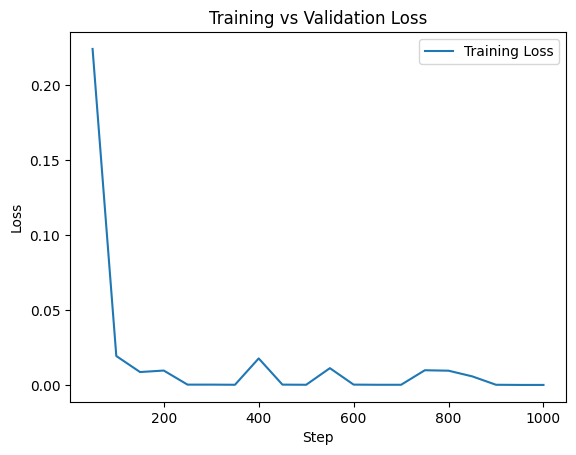

In [19]:
import json, pandas as pd, matplotlib.pyplot as plt

with open("./results/checkpoint-1000/trainer_state.json") as f:
    state = json.load(f)

history = pd.DataFrame(state["log_history"])
plt.plot(history["step"], history["loss"], label="Training Loss")
if "eval_loss" in history.columns:
    plt.plot(history["step"], history["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


## 4. Model Saving and Testing

In [20]:
trainer.save_model("./fake_news_roberta")
tokenizer.save_pretrained("./fake_news_roberta")


('./fake_news_roberta\\tokenizer_config.json',
 './fake_news_roberta\\special_tokens_map.json',
 './fake_news_roberta\\vocab.json',
 './fake_news_roberta\\merges.txt',
 './fake_news_roberta\\added_tokens.json',
 './fake_news_roberta\\tokenizer.json')

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast

model = RobertaForSequenceClassification.from_pretrained("./fake_news_roberta")
tokenizer = RobertaTokenizerFast.from_pretrained("./fake_news_roberta")


In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=-1).item()
    return "FAKE" if preds == 0 else "TRUE"

# Example
print(predict("Breaking news: Aliens landed in New York City!"))
print(predict("The government announced a new economic policy today."))
print(predict("President signs new healthcare reform bill into law."))
print(predict("Shocking! Eating chocolate cures all diseases instantly."))

FAKE
TRUE
TRUE
FAKE


## 5. Visualisations

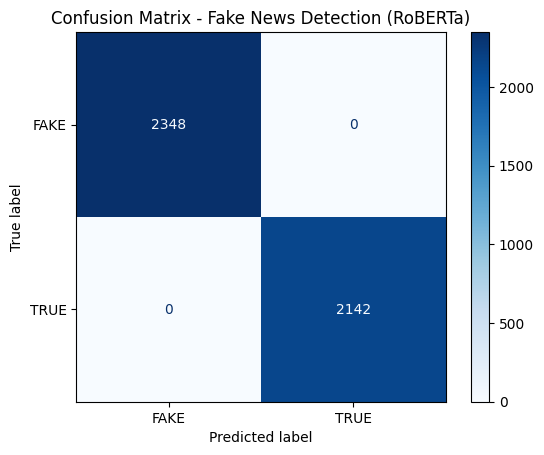

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from trainer
predictions = trainer.predict(test_dataset)

# True labels
y_true = predictions.label_ids

# Predicted labels
y_pred = np.argmax(predictions.predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "TRUE"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - Fake News Detection (RoBERTa)")
plt.show()


In [22]:
from sklearn.metrics import classification_report

# Predictions from trainer
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Generate report
report = classification_report(y_true, y_pred, target_names=["FAKE", "TRUE"])
print(report)


              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2348
        TRUE       1.00      1.00      1.00      2142

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



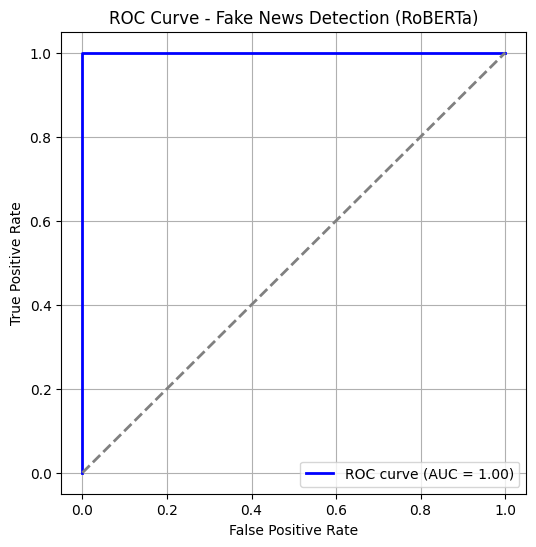

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# Predictions from trainer
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids

# Convert logits to probabilities with softmax
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

# For binary classification, use probability of "TRUE" (class 1)
y_scores = probs[:, 1]

# Binarize labels for ROC
y_true_bin = label_binarize(y_true, classes=[0, 1]).ravel()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fake News Detection (RoBERTa)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
